# Trabalho feito por: 

Thierry Dutoit e Vinicius Lettieri 

In [614]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN, KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn import metrics

# Introdução

Para esse trabalho de clusterização utilizaremos dados de tipos de sementes de trigo, classificados em 3 tipos diferentes e com 7 atributos diferentes:

* Area
* Perimeter
* Compactness
* Kernel Length: Comprimento da Semente
* Kernel Width: Largura da Semente
* Asymmetry
* Kernel Groove Length
* Type -  Classificação do tipo de semente - Será útil para a validação

Os dados originais foram obtidos em https://archive.ics.uci.edu/ml/datasets/seeds

Para o trabalho realizamos um pré-processamento nos dados pois a formatação por coluna não estava correta.

In [615]:
df_original = pd.read_csv("seeds_dataset_treated.csv", sep=';', decimal='.')

In [616]:
df_original

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry,kernel_groove_length,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


### Tratamento dos Dados

In [617]:
from sklearn import preprocessing

Primeiro, vamos verificar se existem linhas duplicadas. Como sabemos, o dataset possui 70 instâncias para cada tipo de semente, tendo ao todo três tipos de semente. Idealmente, para manter a proporção, esperamos não encontrar linhas duplicadas

In [618]:
# Remove linhas duplicadas
data = df_original.drop_duplicates()
lines_qnt, columns_qnt = data.shape
print(lines_qnt, 'linhas e', columns_qnt, 'colunas.')

210 linhas e 8 colunas.


Como podemos ver, as 210 instância dos dataset se mantiveram. Vejamos agora as variâncias relacionadas a cada coluna do dataset.

In [619]:
df = df_original[df_original.columns[:-1]]
df_label = df_original["type"]

In [620]:
# Vamos normalizar os dados para calcular a variância dos atributos
d = preprocessing.normalize(df, axis=0)
data_scaled = pd.DataFrame(d, columns=df.columns)

In [621]:
# Calculando a variância
data_scaled.var()
df = df.drop('compactness', axis=1)

Como a variância da classe compactness é ínfima se comparada às outras, iremos removê-lo. Em nossos testes, após a remoção, os resultados se mantiveram iguais.

### Análise dos Dados

Em uma análise inicial dos dados, como possuímos diversos atributos será dificil interpretarmos de forma multidimensional o espaço dos clusters, então podemos analisar os pares de atributos para pelo menos termos uma noção básica de como se distribuem. Para isso usamos o gráfico PairPlot do Seaborn colorido pelo tipo.

Podemos ver que os tipos de semente são bem definidos para todos os conjuntos de dados, sem muita interseção entre eles. Isso é muito bom pois elimina a incerteza entre os clusters. Contudo, se percebermos, os clusters não são espacialmente separados entre si. Em grande maioria são sub-intervalos definidos. Isso pode se tornar um problema para algoritmos de classificação que dependem de proximidade dos pontos e não recebem uma quantidade inicial de clusters bem definida, é o exemplo do DBSCAN. Essa é uma hipótese inicial que vamos validar.

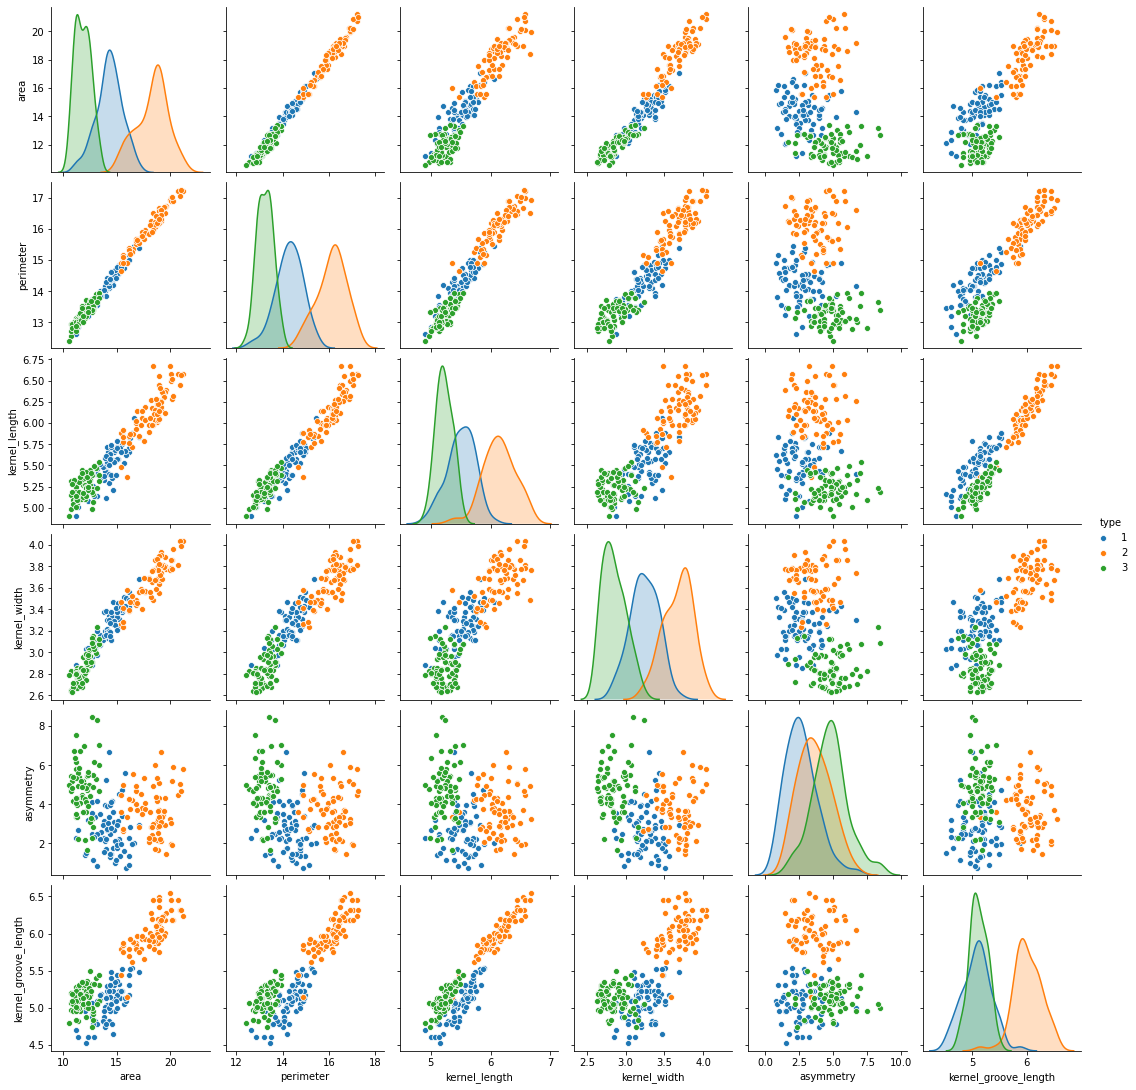

In [622]:
sns.pairplot(df_original, vars=df.columns, hue="type")

Podemos ver que os dados são bem comportados e distribuídos, então tratamento de outliers não será necessário.

# Comparações

Nesta seção temos códigos para extrair métricas e visualizações dos modelos que serão utilizados em seguida.

### Matriz de Contingência

Começamos com a matriz de contingência, que é como uma Matriz de Confusão expandida para múltiplas classes. Através dela conseguimos ver as proporções de classes reais e clusters preditos. O ideal é que sejam agrupados.

In [623]:
def matriz_contingencia(df_comparison):
    cm = pd.DataFrame(
        metrics.cluster.contingency_matrix(df_comparison['class'], df_comparison['cluster']), 
        index=df_comparison['class'].unique(), 
        columns=df_comparison['cluster'].unique()
    )

    sns.heatmap(cm)
    plt.xlabel("Predicao")
    plt.ylabel("Tipo")

    for (x, y), value in np.ndenumerate(cm.T):
        plt.text(
            x+0.5, y+0.5, f"{value}", va="center", ha="center",
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'
        )
    )

### Comparativo de Métricas

Quando tratamos dados com labels de classificação, podemos obter as seguintes métricas:

* **Homogeneidade**: o ideal (1) é quando um cluster possui apenas membros de uma única classe.
* **Completude**: o ideal (1) é quando uma classe está definida apenas para membros do mesmo cluster.
* **V-Measure**: é a média harmônica entre homogeneidade e completude.
* **Fowlkes-Mallows**: mede a similaridade entre elementos dos mesmos clusters.
    
    $ \text{FMI} = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}} $

Para dados sem o conhecimento prévio dos labels, podemos usar as seguintes métricas:

* **Coeficiente de Silhouette**: mede a semelhança entre elementos do mesmo cluster em comparação com os demais clusters. Bons valores indicam uma boa adaptação ao seu próprio cluster.

    Podemos escrever o coeficiente em relação a $a$, distância média entre um ponto e os demais da mesma classe, e $b$, distância média entre um ponto e todos os demais no cluster mais próximo:

    $ \text{Sil} = \frac{b-a}{max(a,b)} $

* **Coeficiente de Calinski-Harabasz**: mede o quão denso um cluster é em relação a quão distante os clusters estão entre si.


**Referências:**
* https://scikit-learn.org/stable/modules/clustering.html

In [624]:
def calculate_metrics(df_comparison, df_X):
    true_classes = df_comparison["class"]
    pred_labels = df_comparison["cluster"]
    print("Homogeneidade dos Clusters [0,1]:", metrics.homogeneity_score(true_classes, pred_labels))
    print("Completude dos Clusters [0,1]:", metrics.completeness_score(true_classes, pred_labels))
    print("Fowlkes-Mallows [0,1]:", metrics.fowlkes_mallows_score(true_classes, pred_labels))
    print("Coeficiente de Silhouette [-1,1]:", metrics.silhouette_score(df_X, pred_labels))
    print("Coeficiente de Calinski-Harabasz:", metrics.calinski_harabasz_score(df_X, pred_labels))


# KMEANS

Começaremos com o Kmeans, que é um dos mais clássicos, e possui algumas versões. Neste caso testaremos o Kmeans padrão e o Bisecting Kmeans.

## KMEANS Padrão

Como sabemos previamente que são 3 tipos de semente podemos especificar a quantidade de clusters com certeza.

In [625]:
def run_kmeans():
    kmeans_data = {}

    kmeans_data['model'] = KMeans(n_clusters=3, random_state=5)
    kmeans_data['model'].fit(df)

    kmeans_data['df_comparison'] = pd.DataFrame({
        "class": df_label,
        "cluster": kmeans_data['model'].labels_
    })
    matriz_contingencia(kmeans_data["df_comparison"])

    calculate_metrics(kmeans_data["df_comparison"], df)

    return kmeans_data

Homogeneidade dos Clusters [0,1]: 0.6934607041029826
Completude dos Clusters [0,1]: 0.696395547296022
Fowlkes-Mallows [0,1]: 0.8106151670655933
Coeficiente de Silhouette [-1,1]: 0.4719633091536002
Coeficiente de Calinski-Harabasz: 375.84362796733524


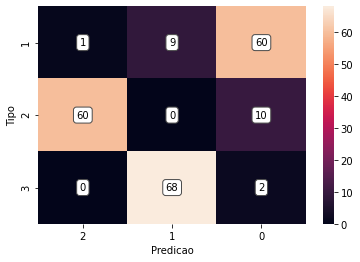

In [626]:
kmeans_data = run_kmeans()

De forma geral tivemos um bom resultado. Conseguimos ver pela matriz de contigência que os clusters ficaram bem definidos, com poucos erros entre eles.

Também obtivemos boas métricas iniciais. Homogeneidade e Completude refletem a boa matriz de contigência.

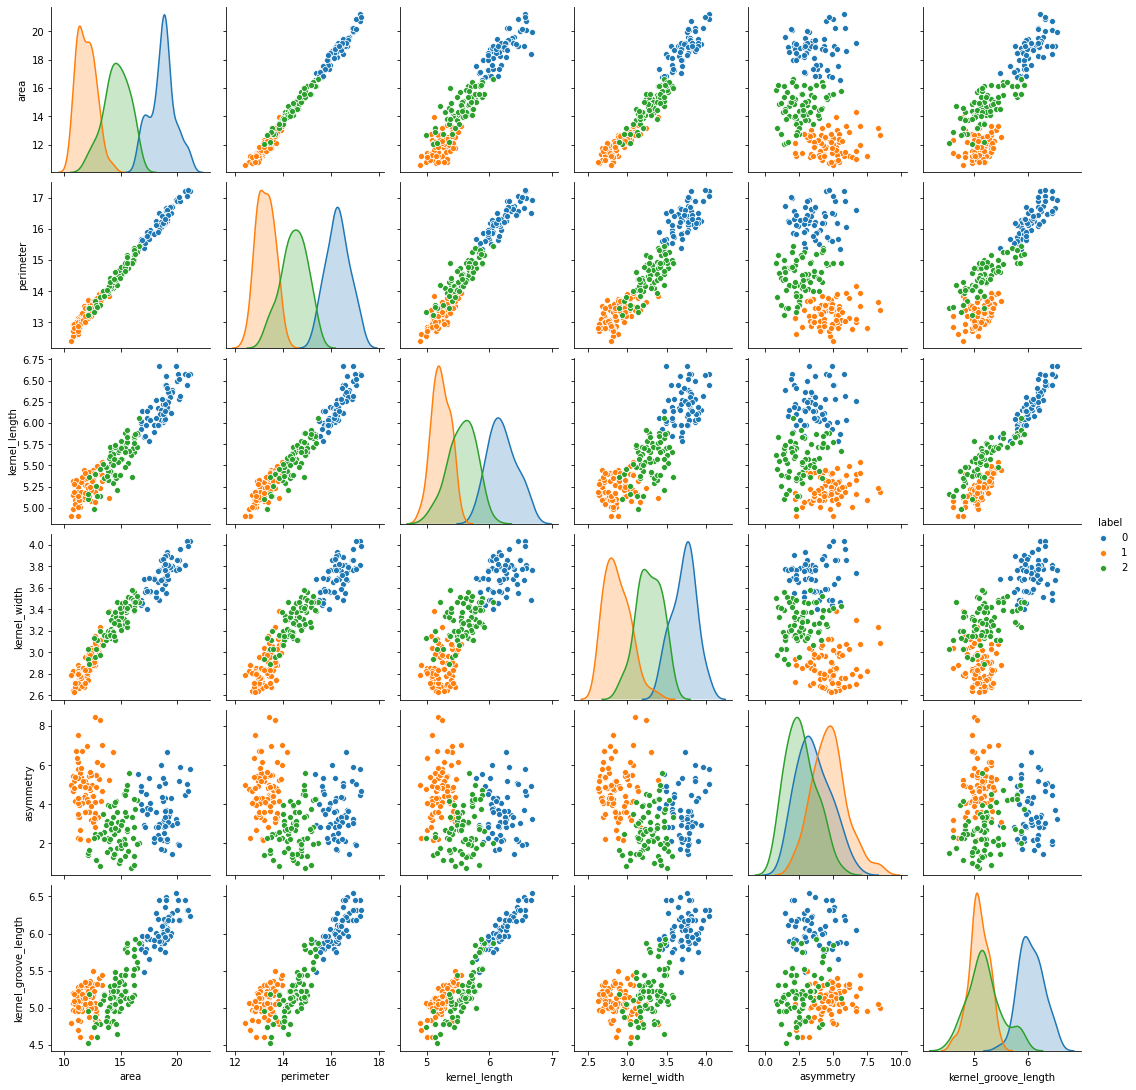

In [627]:
df2 = df.copy()
df2['label'] = kmeans_data["model"].labels_
sns.pairplot(df2, vars=df.columns, hue='label')

Podemos ver que as aglomerações estão bem semelhantes às originais.

## KMEANS Bisecting

In [628]:
def run_bikmeans():
    bikmeans_data = {}

    bikmeans_data['model'] = BisectingKMeans(n_clusters=3, random_state=42)
    bikmeans_data['model'].fit(df)

    bikmeans_data['df_comparison'] = pd.DataFrame({
        "class": df_label,
        "cluster": bikmeans_data['model'].labels_
    })
    matriz_contingencia(bikmeans_data["df_comparison"])

    calculate_metrics(bikmeans_data["df_comparison"], df)

    return bikmeans_data

Homogeneidade dos Clusters [0,1]: 0.6096161818623395
Completude dos Clusters [0,1]: 0.6165967525808717
Fowlkes-Mallows [0,1]: 0.7523245804813455
Coeficiente de Silhouette [-1,1]: 0.4183982532659454
Coeficiente de Calinski-Harabasz: 305.66884103849844


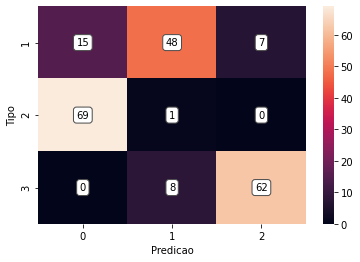

In [629]:
bikmeans_data = run_bikmeans()

Em comparação com o KMeans tradicional a versão Bisecting teve resultados piores, apesar de ainda relevantes. Pudemos ver uma piora em todas as métricas.

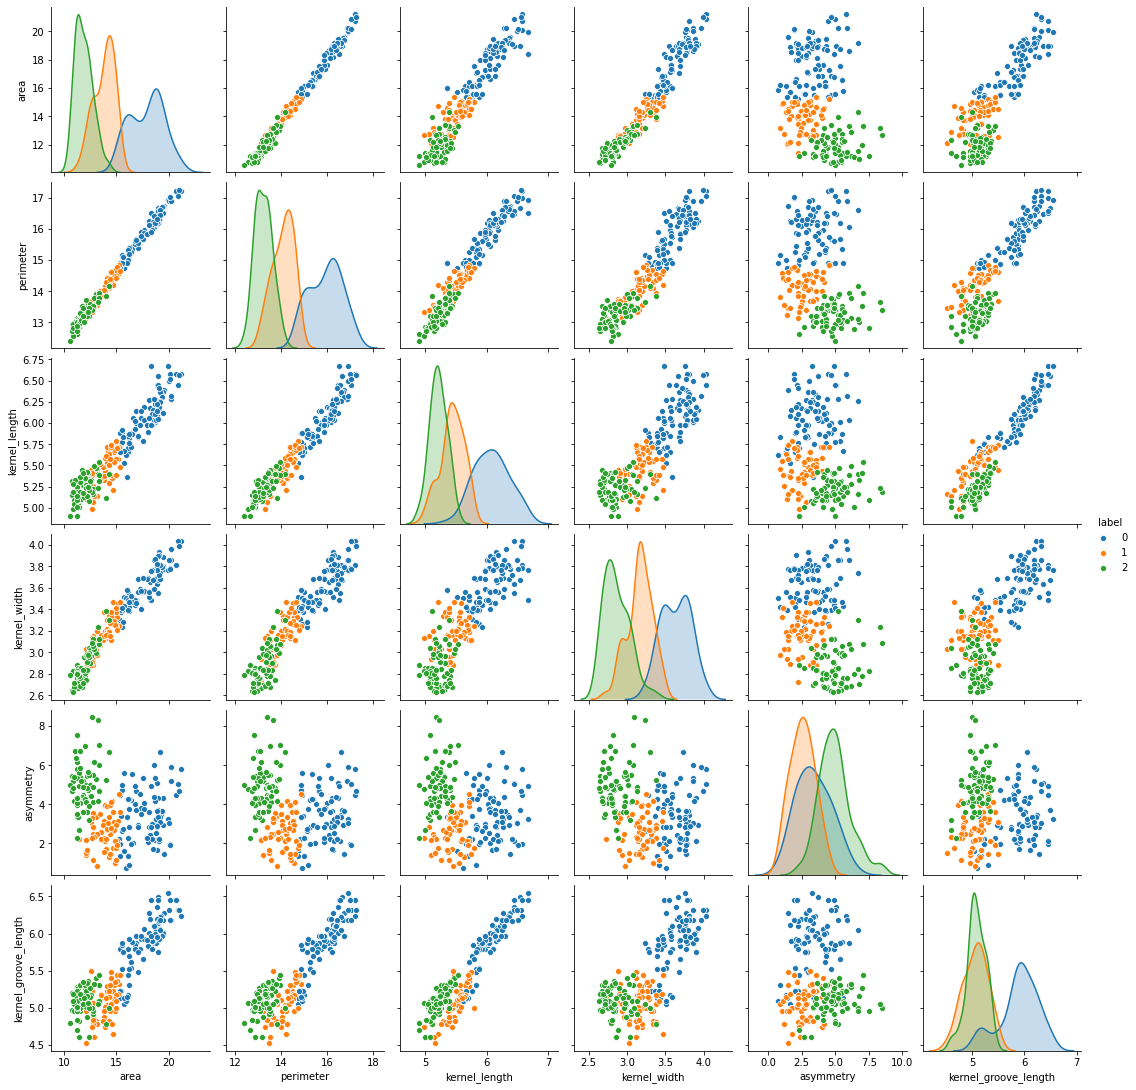

In [630]:
df2 = df.copy()
df2['label'] = bikmeans_data["model"].labels_
sns.pairplot(df2, vars=df.columns, hue='label')

Nesse caso também fica bem próximo dos agrupamentos originais, mas com alguns detalhes mais distorcidos, como na assimetria.

# Aglomerative Clustering 

### Por Máximo

In [631]:
def run_aglomerative_max():
    aglomerative_max_data = {}

    aglomerative_max_data['model'] = AgglomerativeClustering(n_clusters=3, linkage="complete")
    aglomerative_max_data['model'].fit(df)

    aglomerative_max_data['df_comparison'] = pd.DataFrame({
        "class": df_label,
        "cluster": aglomerative_max_data['model'].labels_
    })
    matriz_contingencia(aglomerative_max_data["df_comparison"])

    calculate_metrics(aglomerative_max_data["df_comparison"], df)

    return aglomerative_max_data

Homogeneidade dos Clusters [0,1]: 0.5560096960337604
Completude dos Clusters [0,1]: 0.5820124571876943
Fowlkes-Mallows [0,1]: 0.652683019115858
Coeficiente de Silhouette [-1,1]: 0.4186455755022529
Coeficiente de Calinski-Harabasz: 309.4205754644151


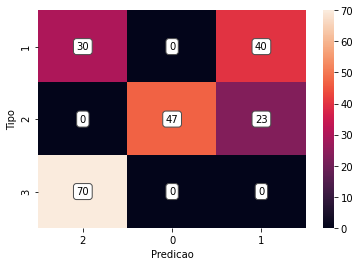

In [632]:
aglomerative_max_data = run_aglomerative_max()

### Por Ward - Minimização de Variância entre Clusters

In [633]:
def run_aglomerative_ward():
    aglomerative_ward_data = {}

    aglomerative_ward_data['model'] = AgglomerativeClustering(n_clusters=3, linkage="ward")
    aglomerative_ward_data['model'].fit(df)

    aglomerative_ward_data['df_comparison'] = pd.DataFrame({
        "class": df_label,
        "cluster": aglomerative_ward_data['model'].labels_
    })
    matriz_contingencia(aglomerative_ward_data["df_comparison"])

    calculate_metrics(aglomerative_ward_data["df_comparison"], df)

    return aglomerative_ward_data

Homogeneidade dos Clusters [0,1]: 0.7266916689197686
Completude dos Clusters [0,1]: 0.7352022993399162
Fowlkes-Mallows [0,1]: 0.809168863736427
Coeficiente de Silhouette [-1,1]: 0.44939178109162176
Coeficiente de Calinski-Harabasz: 352.87128097112355


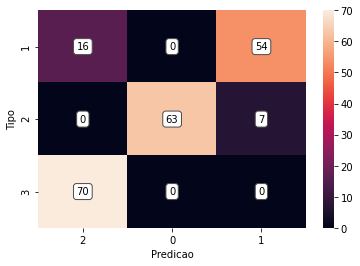

In [634]:
aglomerative_ward_data = run_aglomerative_ward()

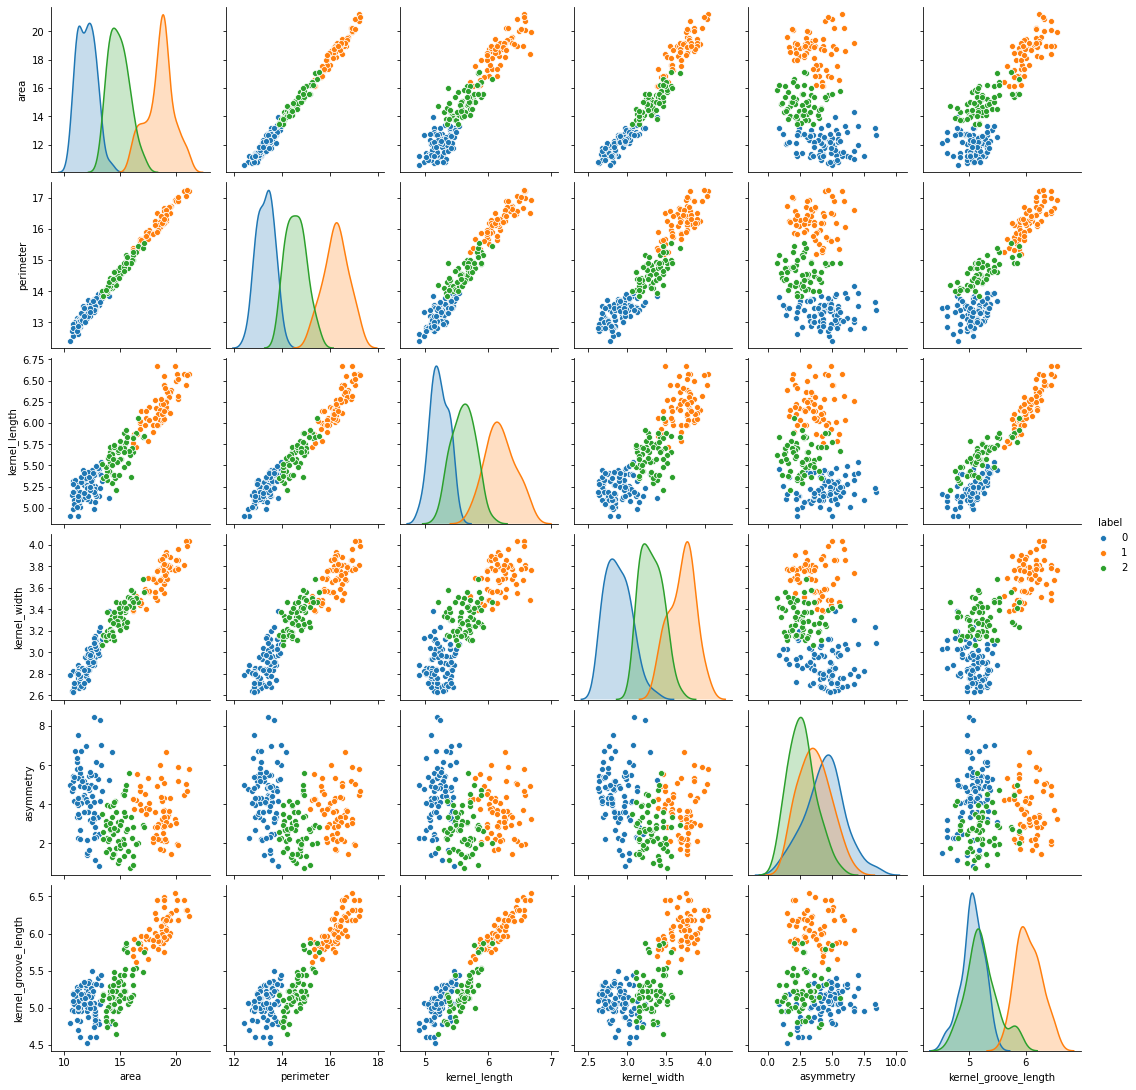

In [635]:
df2 = df.copy()
df2['label'] = aglomerative_ward_data["model"].labels_
sns.pairplot(df2, vars=df.columns, hue='label')

# DBSCAN

In [636]:
len(df.columns)

6

Para a quantidade mínima de samples utilizamos o padrão da literatura de 2*n colunas. Testamos com outros tamanhos mas esse deu resultados satisfatórios. Em relação ao eps, conseguimos determinar um ponto ótimo através de testes. Quando o resultado possui muitos -1 significa que o eps está pequeno demais e quando possui muitos de uma classe só significa que o eps está grande demais. Chegamos ao ponto ótimo de 0.85 dividindo em três classes.

In [637]:
def run_dbscan():
    dbscan_data = {}

    dbscan_data['model'] = DBSCAN(eps=0.85, min_samples=12)
    dbscan_data['model'].fit(df)

    dbscan_data['df_comparison'] = pd.DataFrame({
        "class": df_label,
        "cluster": dbscan_data['model'].labels_
    })
    matriz_contingencia(dbscan_data["df_comparison"])

    calculate_metrics(dbscan_data["df_comparison"], df)

    return dbscan_data

Homogeneidade dos Clusters [0,1]: 0.5281889325265193
Completude dos Clusters [0,1]: 0.4570364479718159
Fowlkes-Mallows [0,1]: 0.5557541217400822
Coeficiente de Silhouette [-1,1]: 0.14599360071148415
Coeficiente de Calinski-Harabasz: 75.53161008781233


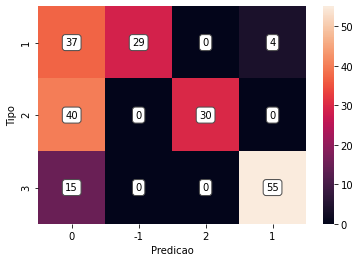

In [638]:
dbscan_data = run_dbscan()

Podemos ver resultados consideravelmente mais baixos. Isso foi uma hipótese esperada, devido ao tipo de dados que trabalhamos. Como o DBSCAN se dá melhor com clusters de elementos próximos e clusters bem separados, nossos dados que são pontos próximos dos outros não encaixam bem.

Conseguimos inclusive ver no gráfico a seguir, das distribuições em pares, que o DBSCAN captura clusters bem separados, ignorando os pontos entre.

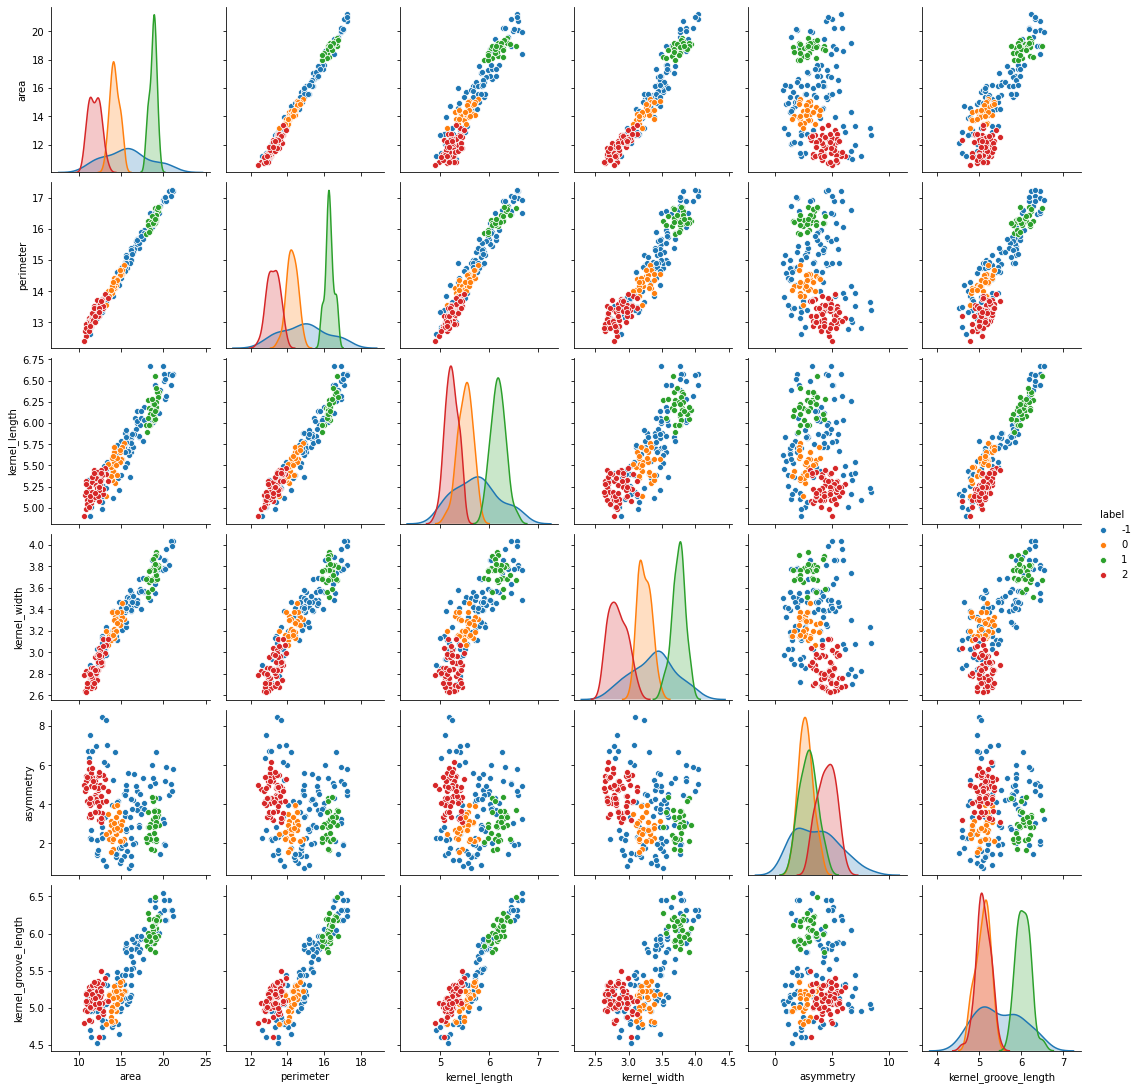

In [639]:
df2 = df.copy()
df2['label'] = dbscan_data["model"].labels_
sns.pairplot(df2, vars=df.columns, hue='label')

# Conclusões

### Métricas

$$
\begin{array}{c:ccccccc}
Métricas & Kmeans & BisectingKmeans & AglomerativeMax & AglomerativeWard & DBSCAN \\ \hline
Homogeneidade & [0.69] & [0.61] & [0.56] & [0.73] & [0.53] \\
Completude & [0.70] & [0.62] & [0.58] & [0.73] & [0.46] \\ 
Fowlkes-Mallows & [0.81] & [0.75] & [0.65] & [0.81] & [0.55] \\
Silhouette & [0.47] & [0.42] & [0.42] & [0.45] & [0.14] \\
Calinski-Harabasz & [375.84] & [305.67] & [309.42] & [352.87] & [75.53] \\
\end {array}
$$

Em uma análise por métricas temos os melhores:
* Homogeneidade: Aglomerative com Ward
* Completude: Aglomerative com Ward
* Fowlkes-Mallows: Kmeans ou Aglomerative com Ward
* Silhouette: Kmeans
* Calisnki-Harabasz: Kmeans

Vemos que para esse dataset o KMeans e o AglomerativeClustering tiveram um melhor desempenho em clusterizar corretamente as classes. Ambos tiveram boas medidas, e conseguiram acertar boa parte do que estava definido no dataset. 

Em contraparida, o BisectingKmeans e o DBScan tiveram dificuldades em clusterizar corretamente o dataset. Sabemos que o DBScan funciona bem quando os clusters possuem uma grande distância entre si e uma distância pequena entre os vizinhos de um mesmo cluster. Essas duas premissas não são verdadeiras em nosso dataset, e por isso ele tive dificuldade.  Para o BisectingKmeans, parece que ele funciona melhor quando o número de clusters é relativamente grande. De acordo com essa matéria https://medium.com/@afrizalfir/bisecting-kmeans-clustering-5bc17603b8a2, ele diz que o BisectingKmeans é melhor quando K é grande. Dessa forma, faz sentido o Kmeans e o AgloremativeClustering obterem um desempenho melhor nesse dataset.